# <font color='blue'>Previsão de ocorrência de doença hepática</font>

In [1]:
# versão da linguagem Python
from platform import python_version
print('Versão do Python utilizado neste Jupyter Notebook:', python_version())

Versão do Python utilizado neste Jupyter Notebook: 3.9.12


In [2]:
# Imports
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

In [3]:
#!pip install sklearn==1.1.1 

In [4]:
# Versões dos pacotes usados neste Jupyter Notebook
%reload_ext watermark
%watermark -a "Pedro Leonardo" --iversions

Author: Pedro Leonardo

pandas    : 1.4.2
joblib    : 1.1.0
matplotlib: 3.5.2
numpy     : 1.22.4
seaborn   : 0.11.2
sklearn   : 1.1.1



## Carregando o Conjunto de dados

In [5]:
# Carrega os dados
dados = pd.read_csv('dados/dataset.csv')

In [6]:
# Shape
dados.shape

(583, 11)

In [7]:
# Columns
dados.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Dataset'],
      dtype='object')

In [8]:
# Sample of the data
dados.sample(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
360,24,Male,0.7,0.2,218,47,26,6.6,3.3,1.0,1
514,49,Male,1.0,0.3,230,48,58,8.4,4.2,1.0,1
494,25,Male,0.7,0.2,185,196,401,6.5,3.9,1.5,1
339,75,Male,1.4,0.4,215,50,30,5.9,2.6,0.7,1
535,60,Male,19.6,9.5,466,46,52,6.1,2.0,0.4,1


## Análise Exploratória de Dados

In [9]:
# Tipos de dados
dados.dtypes

Age                             int64
Gender                         object
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object

In [10]:
# Variáveis categóricas
dados.dtypes[dados.dtypes == 'object']

Gender    object
dtype: object

In [11]:
# Variáveis não categóricas
dados.dtypes[dados.dtypes != 'object']

Age                             int64
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object

### Exploração das Variáveis Numéricas

In [12]:
dados.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


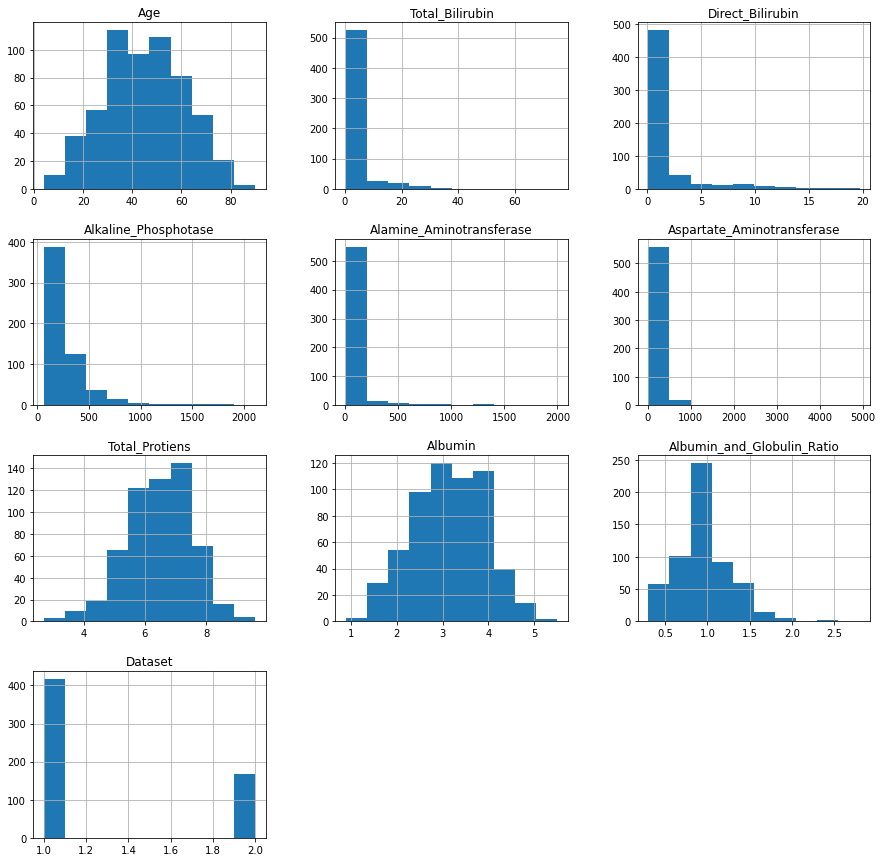

In [13]:
# Plot
dados.hist(figsize = (15,15), bins = 10)
plt.show()

Parece que há outlier nas variáveis **Alamine_Aminotransferase**, **Aspartate_Aminotransferase**, pois o valor máximo é muito mais alto que o valor médio.

A coluna dataset (variável target) tem '1' para doença hepática e '2' para nenhuma doença hepática. Vamos ajustar a variável colocando valores mais fáceis de interpretar. A classe negativa (não tem a doença) será zero.

In [14]:
# Função para ajustar a variável target
def ajusta_var(x):
    if x == 2:
        return 0
    return 1

In [15]:
# Aplica a função
dados['Dataset'] = dados['Dataset'].map(ajusta_var)

In [16]:
# Ajustando o nome da variável target
dados.rename({'Dataset': 'Target'}, axis = 'columns', inplace = True)

In [17]:
dados.sample(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
78,70,Male,1.4,0.6,146,12,24,6.2,3.8,1.58,0
437,35,Male,1.6,0.7,157,15,44,5.2,2.5,0.90,1
291,60,Male,0.7,0.2,174,32,14,7.8,4.2,1.10,0
341,36,Female,0.8,0.2,650,70,138,6.6,3.1,0.80,1
448,48,Female,0.8,0.2,142,26,25,6.0,2.6,0.70,1


In [18]:
# Correlação entre as variáveis
dados.corr()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
Age,1.000000,0.011763,0.007529,0.080425,-0.086883,-0.019910,-0.187461,-0.265924,-0.216408,0.137351
Total_Bilirubin,0.011763,1.000000,0.874618,0.206669,0.214065,0.237831,-0.008099,-0.222250,-0.206267,0.220208
Direct_Bilirubin,0.007529,0.874618,1.000000,0.234939,0.233894,0.257544,-0.000139,-0.228531,-0.200125,0.246046
Alkaline_Phosphotase,0.080425,0.206669,0.234939,1.000000,0.125680,0.167196,-0.028514,-0.165453,-0.234166,0.184866
Alamine_Aminotransferase,-0.086883,0.214065,0.233894,0.125680,1.000000,0.791966,-0.042518,-0.029742,-0.002375,0.163416
Aspartate_Aminotransferase,-0.019910,0.237831,0.257544,0.167196,0.791966,1.000000,-0.025645,-0.085290,-0.070040,0.151934
Total_Protiens,-0.187461,-0.008099,-0.000139,-0.028514,-0.042518,-0.025645,1.000000,0.784053,0.234887,-0.035008
Albumin,-0.265924,-0.222250,-0.228531,-0.165453,-0.029742,-0.085290,0.784053,1.000000,0.689632,-0.161388
Albumin_and_Globulin_Ratio,-0.216408,-0.206267,-0.200125,-0.234166,-0.002375,-0.070040,0.234887,0.689632,1.000000,-0.163131
Target,0.137351,0.220208,0.246046,0.184866,0.163416,0.151934,-0.035008,-0.161388,-0.163131,1.000000


Variáveis com correlação acima ou abaixo de 0,7 podem tornar a análise de ML tendenciosa por representar duas variáveis que contém a mesma informação.

será necessário realizar um tratamento em algumas destas duas variáveis com alta correlação

### Exploração da Variável Categórica

In [19]:
dados.describe(include = ['object'])

,Gender
count,583
unique,2
top,Male
freq,441


Número de pacientes do sexo masculino:  441
Número de pacientes do sexo feminino:  142


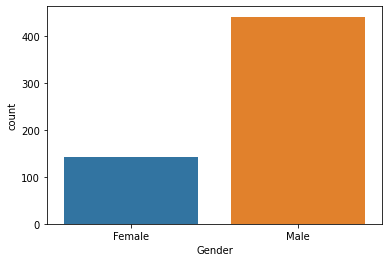

In [20]:
# Plot 
sns.countplot(data = dados, x = 'Gender', label = 'Count')

# Value counts
M, F = dados['Gender'].value_counts()

# Print
print('Número de pacientes do sexo masculino: ', M)
print('Número de pacientes do sexo feminino: ', F)

Vamos aproveitar e já transformar a variável categórica em sua representação numérica usando label encoding. Além de reduzir o trabalho mais tarde, facilitará a criação de gráficos a seguir.

In [21]:
# Função para label enconding
def encoding_func(x):
    if x == 'Male':
        return 0
    return 1

In [22]:
# Aplicando a função
dados['Gender'] = dados['Gender'].map(encoding_func)

In [23]:
dados.sample(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
452,58,0,0.9,0.2,1100,25,36,7.1,3.5,0.90,1
78,70,0,1.4,0.6,146,12,24,6.2,3.8,1.58,0
74,68,0,0.7,0.1,145,20,22,5.8,2.9,1.00,1
210,28,0,0.8,0.3,190,20,14,4.1,2.4,1.40,1
72,75,1,0.8,0.2,205,27,24,4.4,2.0,0.80,1


### Verificando a Relação Entre Atributos

In [24]:
dados.corr()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
Age,1.000000,-0.056560,0.011763,0.007529,0.080425,-0.086883,-0.019910,-0.187461,-0.265924,-0.216408,0.137351
Gender,-0.056560,1.000000,-0.089291,-0.100436,0.027496,-0.082332,-0.080336,0.089121,0.093799,0.003424,-0.082416
Total_Bilirubin,0.011763,-0.089291,1.000000,0.874618,0.206669,0.214065,0.237831,-0.008099,-0.222250,-0.206267,0.220208
Direct_Bilirubin,0.007529,-0.100436,0.874618,1.000000,0.234939,0.233894,0.257544,-0.000139,-0.228531,-0.200125,0.246046
Alkaline_Phosphotase,0.080425,0.027496,0.206669,0.234939,1.000000,0.125680,0.167196,-0.028514,-0.165453,-0.234166,0.184866
Alamine_Aminotransferase,-0.086883,-0.082332,0.214065,0.233894,0.125680,1.000000,0.791966,-0.042518,-0.029742,-0.002375,0.163416
Aspartate_Aminotransferase,-0.019910,-0.080336,0.237831,0.257544,0.167196,0.791966,1.000000,-0.025645,-0.085290,-0.070040,0.151934
Total_Protiens,-0.187461,0.089121,-0.008099,-0.000139,-0.028514,-0.042518,-0.025645,1.000000,0.784053,0.234887,-0.035008
Albumin,-0.265924,0.093799,-0.222250,-0.228531,-0.165453,-0.029742,-0.085290,0.784053,1.000000,0.689632,-0.161388
Albumin_and_Globulin_Ratio,-0.216408,0.003424,-0.206267,-0.200125,-0.234166,-0.002375,-0.070040,0.234887,0.689632,1.000000,-0.163131


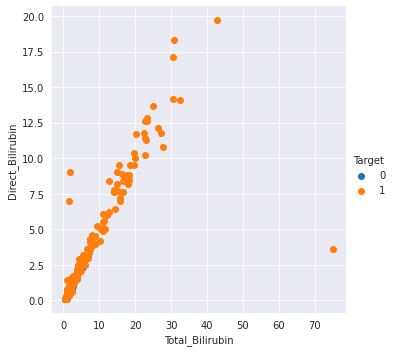

In [25]:
# Definindo o estilo do background
sns.set_style('darkgrid')

# Facetgrid
sns.FacetGrid(dados, hue = 'Target', size = 5).map(plt.scatter, 'Total_Bilirubin', 'Direct_Bilirubin').add_legend();

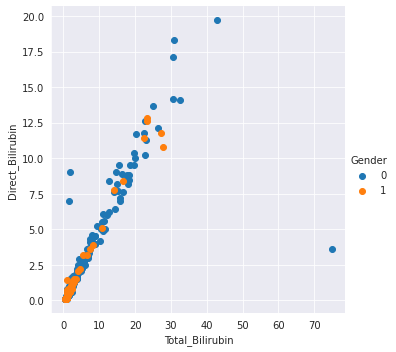

In [26]:
# Definindo o estilo do background
sns.set_style('darkgrid')

# Facetgrid 
sns.FacetGrid(dados, hue = 'Gender', size = 5).map(plt.scatter, 'Total_Bilirubin', 'Direct_Bilirubin').add_legend();

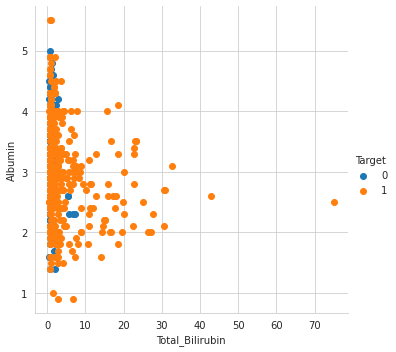

In [27]:
# Background
sns.set_style('whitegrid')

#facetGrid
sns.FacetGrid(dados, hue = 'Target', size = 5).map(plt.scatter, 'Total_Bilirubin', 'Albumin').add_legend();

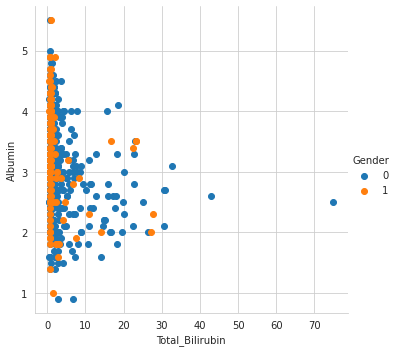

In [28]:
# Background
sns.set_style('whitegrid')

# Facetgrid
sns.FacetGrid(dados, hue = 'Gender', size = 5).map(plt.scatter, 'Total_Bilirubin', 'Albumin').add_legend();

### Verificando Valores Ausentes e Registros Duplicados

In [29]:
# Verificando valores ausentes
dados[dados.isnull().values]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
209,45,1,0.9,0.3,189,23,33,6.6,3.9,NaN,1
241,51,0,0.8,0.2,230,24,46,6.5,3.1,NaN,1
253,35,1,0.6,0.2,180,12,15,5.2,2.7,NaN,0
312,27,0,1.3,0.6,106,25,54,8.5,4.8,NaN,0


In [30]:
# Verificando registros duplicados (complete cases)
# Complete cases também se refere a linhas onde não há valores ausentes
dados[dados.duplicated(keep = False)]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
18,40,1,0.9,0.3,293,232,245,6.8,3.1,0.80,1
19,40,1,0.9,0.3,293,232,245,6.8,3.1,0.80,1
25,34,0,4.1,2.0,289,875,731,5.0,2.7,1.10,1
26,34,0,4.1,2.0,289,875,731,5.0,2.7,1.10,1
33,38,1,2.6,1.2,410,59,57,5.6,3.0,0.80,0
34,38,1,2.6,1.2,410,59,57,5.6,3.0,0.80,0
54,42,0,8.9,4.5,272,31,61,5.8,2.0,0.50,1
55,42,0,8.9,4.5,272,31,61,5.8,2.0,0.50,1
61,58,0,1.0,0.5,158,37,43,7.2,3.6,1.00,1
62,58,0,1.0,0.5,158,37,43,7.2,3.6,1.00,1


## Limpeza da Dados

### Tratamento de Registros Duplicados

In [31]:
dados.shape

(583, 11)

In [32]:
# Remover registros duplicados (remove uma das linhas duplicadas)
dados = dados.drop_duplicates()
print(dados.shape)

(570, 11)


### Tratamento de Outliers

In [33]:
dados.describe()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
count,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,566.000000,570.000000
mean,44.849123,0.245614,3.321754,1.497544,291.750877,79.728070,109.380702,6.496316,3.148947,0.948004,0.712281
std,16.242182,0.430829,6.267941,2.833231,245.291859,181.471697,290.880671,1.088300,0.796813,0.319635,0.453097
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,0.000000,0.800000,0.200000,176.000000,23.000000,25.000000,5.800000,2.600000,0.700000,0.000000
50%,45.000000,0.000000,1.000000,0.300000,208.000000,35.000000,41.000000,6.600000,3.100000,0.950000,1.000000
75%,58.000000,0.000000,2.600000,1.300000,298.000000,60.000000,86.750000,7.200000,3.800000,1.100000,1.000000
max,90.000000,1.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,1.000000


<AxesSubplot:xlabel='Alamine_Aminotransferase'>

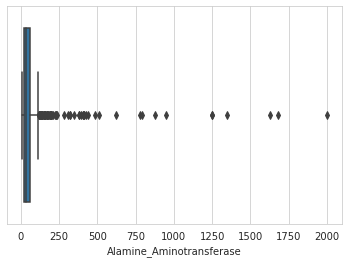

In [34]:
# boxplot
sns.boxplot(dados.Alamine_Aminotransferase)

Será que os valores extremos são mesmo outliers?

In [35]:
# Contagem de frequência por valor
dados.Alamine_Aminotransferase.sort_values(ascending = False).head()

117    2000
27     1680
47     1630
118    1350
135    1250
Name: Alamine_Aminotransferase, dtype: int64

Como tem muitos indivíduos com o valor de 2000 é necessário consultar o especialista técnico no assunto para realizar a retirada ou não destes elementos, então eles permanecerão

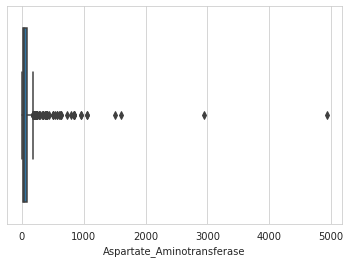

In [36]:
# Boxplot
sns.boxplot(dados.Aspartate_Aminotransferase);

In [37]:
# Contagem de frequencia por valor
dados.Aspartate_Aminotransferase.sort_values(ascending = False).head()

135    4929
117    2946
118    1600
207    1500
199    1050
Name: Aspartate_Aminotransferase, dtype: int64

Por uma decisão de negócio, serão mantidos apenas os paciente com o valor de até 3000 para a Aspartate_Aminotransferase

In [38]:
# Manter somente os registros onde o valor for menor ou igual a 3000
dados = dados[dados.Aspartate_Aminotransferase <= 3000]
dados.shape

(569, 11)

<AxesSubplot:xlabel='Aspartate_Aminotransferase'>

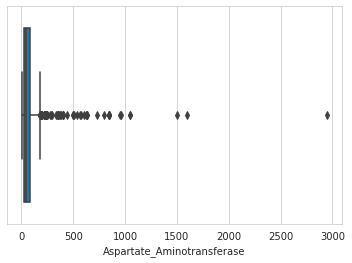

In [39]:
# Boxplot
sns.boxplot(dados.Aspartate_Aminotransferase)

In [40]:
# Contagem de frequência por valor
dados.Aspartate_Aminotransferase.sort_values(ascending = False).head()

117    2946
118    1600
207    1500
119    1050
199    1050
Name: Aspartate_Aminotransferase, dtype: int64

Segunda rodada para retirar valores outliers

In [41]:
# Mantém apenas os registros onde o valor for menor ou igual a 2500
dados = dados[dados.Aspartate_Aminotransferase <= 2500]
dados.shape

(568, 11)

### Tratamento de Valores Ausentes

In [42]:
# Verifica se há valor ausente
dados.isnull().values.any()

True

In [43]:
# Verificar quantas colunas tem valor ausênte
dados.isnull().values.any().sum()

1

In [44]:
# Listar os valores ausentes
dados[dados.isnull().values]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
209,45,1,0.9,0.3,189,23,33,6.6,3.9,NaN,1
241,51,0,0.8,0.2,230,24,46,6.5,3.1,NaN,1
253,35,1,0.6,0.2,180,12,15,5.2,2.7,NaN,0
312,27,0,1.3,0.6,106,25,54,8.5,4.8,NaN,0


In [45]:
dados.shape

(568, 11)

In [46]:
# Drop dos registros com valores ausentes em qualquer coluna (any)
dados = dados.dropna(how = 'any')

In [47]:
dados.shape

(564, 11)

In [48]:
# Listar os valores ausentes
dados[dados.isnull().values]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target


In [49]:
dados.sample(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
530,22,1,1.1,0.3,138,14,21,7.0,3.8,1.1,0
9,55,0,0.7,0.2,290,53,58,6.8,3.4,1.0,1
278,45,0,2.2,0.8,209,25,20,8.0,4.0,1.0,1
537,10,1,0.8,0.1,395,25,75,7.6,3.6,0.9,1
297,25,1,0.9,0.3,159,24,25,6.9,4.4,1.7,0


## Pré-Processamento de Dados Para Construção de Modelos de Machine Learning


In [50]:
# Dada a alta correlação entre as variáveis Direct_Bilirubin e Total_Bilirubin, vamos remover Direct_Bilirubin
dados = dados.drop('Direct_Bilirubin', 1)

In [51]:
dados.shape

(564, 10)

### Divisão em Treino e Teste

In [52]:
# Criar um objeto separado para a variável target
y = dados.Target

In [53]:
# Criar um objeto separado para as vriáveis de entrada
x = dados.drop('Target', axis = 1)

In [54]:
# Splt em dados de treino e teste com amostragem estratificada
x_treino, x_teste, y_treino, y_teste = train_test_split(x,
                                                        y,
                                                        test_size = 0.25,
                                                        random_state = 1234,
                                                        stratify = dados.Target)

In [55]:
len(x_treino)

423

In [56]:
len(x_teste)

141

In [57]:
# Print do shape
print(x_treino.shape, x_teste.shape, y_treino.shape, y_teste.shape)

(423, 9) (141, 9) (423,) (141,)


### Balanceamento de classe

O objetivo é manter as duas classes com uma quantidade semelhante, para o nosso caso é possível reduzir a quantidade de amostras '1' no intuito que elas tenham quantidade semelhante a '0' ou aumentar a quandatidade de amostras '0' para que elas sejam semelhantes a quantidade de amostras '1', e é o que faremos.

In [58]:
y_treino.value_counts()

1    301
0    122
Name: Target, dtype: int64

In [59]:
# Install the package
#!pip install -q imblearn

In [60]:
# load the SMOTE function
import imblearn
from imblearn.over_sampling import SMOTE

In [61]:
# Package version used at this jupyter notebook
%reload_ext watermark
%watermark -a "Pedro Costa" --iversions

Author: Pedro Costa

pandas    : 1.4.2
joblib    : 1.1.0
matplotlib: 3.5.2
imblearn  : 0.0
numpy     : 1.22.4
seaborn   : 0.11.2
sklearn   : 1.1.1



In [62]:
# Aplicar a técnica de oversampling e aumentar o número de exemplos da classe minoritária
over_sampler = SMOTE(k_neighbors = 2)

In [63]:
# Aplicar o oversampling (must be made at training sample only)
x_res, y_res = over_sampler.fit_resample(x_treino, y_treino)

In [64]:
len(x_res)

602

In [65]:
len(y_res)

602

In [66]:
y_res.value_counts()

1    301
0    301
Name: Target, dtype: int64

In [67]:
# Adjust training dataset name for 'x'
x_treino = x_res

In [68]:
# Adjust training dataset name for 'y'
y_treino = y_res

### Padronização dos Dados

In [69]:
x_treino.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,45,0,2.5,163,28,22,7.6,4.0,1.1
1,72,0,0.8,148,23,35,6.0,3.0,1.0
2,18,0,0.8,282,72,140,5.5,2.5,0.8
3,42,0,8.9,272,31,61,5.8,2.0,0.5
4,42,0,0.8,127,29,30,4.9,2.7,1.2


In [70]:
# Calcular a média e desvio padrão dos dados de treino
treino_mean = x_treino.mean()
treino_std = x_treino.std()
print(treino_mean)
print(treino_std)

Age                            43.578073
Gender                          0.209302
Total_Bilirubin                 2.667415
Alkaline_Phosphotase          268.445183
Alamine_Aminotransferase       62.094684
Aspartate_Aminotransferase     77.117940
Total_Protiens                  6.515384
Albumin                         3.226647
Albumin_and_Globulin_Ratio      0.989806
dtype: float64
Age                            16.018647
Gender                          0.407149
Total_Bilirubin                 5.567631
Alkaline_Phosphotase          220.655953
Alamine_Aminotransferase      140.108192
Aspartate_Aminotransferase    144.122537
Total_Protiens                  1.017156
Albumin                         0.765191
Albumin_and_Globulin_Ratio      0.309547
dtype: float64


In [71]:
# Padronização
x_treino = (x_treino - treino_mean) / treino_std

In [72]:
x_treino.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,0.088767,-0.514068,-0.030069,-0.477871,-0.243345,-0.382438,1.066322,1.010667,0.355986
1,1.774303,-0.514068,-0.335406,-0.545851,-0.279032,-0.292237,-0.506691,-0.296197,0.032934
2,-1.596769,-0.514068,-0.335406,0.061430,0.070698,0.436310,-0.998258,-0.949629,-0.613171
3,-0.098515,-0.514068,1.119432,0.016110,-0.221933,-0.111835,-0.703318,-1.603061,-1.582328
4,-0.098515,-0.514068,-0.335406,-0.641021,-0.236208,-0.326930,-1.588138,-0.688256,0.679038


In [73]:
# Describe
x_treino.describe()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
count,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02
mean,2.467572e-16,5.064240e-16,-1.927214e-16,-3.762218e-17,-3.955861e-17,6.325689e-17,1.085326e-15,-1.871473e-15,3.572943e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.470750e+00,-5.140683e-01,-4.072495e-01,-9.310657e-01,-3.718175e-01,-4.657005e-01,-3.751032e+00,-3.040611e+00,-2.228433e+00
25%,-7.227872e-01,-5.140683e-01,-3.424388e-01,-4.359510e-01,-2.861695e-01,-3.685610e-01,-6.050048e-01,-6.882561e-01,-6.131711e-01
50%,8.876698e-02,-5.140683e-01,-3.174447e-01,-3.192535e-01,-2.219334e-01,-2.852985e-01,2.921802e-02,-3.482414e-02,3.293351e-02
75%,7.130394e-01,-5.140683e-01,-1.557961e-01,5.236576e-02,-7.204921e-02,-7.714227e-02,6.730689e-01,7.629263e-01,4.856452e-01
max,2.897993e+00,1.942036e+00,1.299163e+01,8.345820e+00,1.154754e+01,1.056658e+01,3.032590e+00,2.970963e+00,5.847875e+00


In [74]:
# Usando média e desvio de TREINO para padronizar o conjunto de dados de teste
x_teste = (x_teste - treino_mean) / treino_std

A padronização dos dados de TESTE tem que usar o mesmo padrão aplicado nos dados de TREINO porque foi assim que o modelo aprendeu

- toda e qualquer transformação aplicada em treino tem que ser aplicada em testes e em novos dados

In [75]:
x_teste.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
220,-0.410651,-0.514068,-0.335406,-0.550383,-0.250483,-0.215913,-1.489825,-0.949629,0.032934
448,0.276049,1.942036,-0.335406,-0.573042,-0.257620,-0.361622,-0.506691,-0.818943,-0.936223
509,0.151194,-0.514068,3.113099,-0.065465,0.556037,3.211726,-1.096572,-0.296197,0.679038
415,1.649448,-0.514068,-0.245601,1.910462,0.220582,-0.257544,-2.866212,-0.688256,-0.936223
56,-0.660360,-0.514068,-0.335406,-0.319253,-0.257620,-0.375499,1.459576,1.010667,0.032934


## Construção, Treinamento e Avaliação do Modelo 1 com Regressão Logística (Benchmark)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Para a primeira versão do modelo o ideal é escolher um algoritmo simples, fácil de compreender e que será usado como Benchmark

In [76]:
# Definir lista de hiperparâmetros
tuned_params_v1 = { 'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
                    'penalty' : ['l1', 'l2']}

In [77]:
# Criar o modelo com GridSearch
# Vários modelos serão criados com diferentes combinações de hiperparâmetros
modelo_v1 = GridSearchCV(LogisticRegression(),
                         tuned_params_v1,
                         scoring = 'roc_auc',
                         n_jobs = -1)


In [78]:
# Treinamento do modelo
modelo_v1.fit(x_treino, y_treino )

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [79]:
# Selecionar o melhor modelo
modelo_v1.best_estimator_

LogisticRegression(C=1)

In [80]:
# Previsões com dados de teste
y_pred_v1 = modelo_v1.predict(x_teste)

In [81]:
# Mostrar as 10 primeiras previsões
y_pred_v1[:10]

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 1])

In [82]:
# Obter as previsões no formato de probabilidade para cada classe
y_pred_proba_v1 = modelo_v1.predict_proba(x_teste)

In [83]:
# Mostrar as 10 primeiras previsões
y_pred_proba_v1[:10]

array([[7.52423112e-01, 2.47576888e-01],
       [5.03834931e-01, 4.96165069e-01],
       [5.20626577e-05, 9.99947937e-01],
       [5.47781476e-01, 4.52218524e-01],
       [6.83107724e-01, 3.16892276e-01],
       [6.01145815e-01, 3.98854185e-01],
       [7.67641438e-01, 2.32358562e-01],
       [1.08925393e-01, 8.91074607e-01],
       [6.69999595e-01, 3.30000405e-01],
       [6.90940859e-03, 9.93090591e-01]])

In [84]:
# Obter as privisões no formato de probabilidade filtrando para a classe positiva
# Precisamos disto para calcular a Curva ROC
y_pred_proba_v1 = modelo_v1.predict_proba(x_teste)[:,1]

In [85]:
# Mostrar as 10 primeiras previsões
y_pred_proba_v1[:10]

array([0.24757689, 0.49616507, 0.99994794, 0.45221852, 0.31689228,
       0.39885418, 0.23235856, 0.89107461, 0.3300004 , 0.99309059])

In [86]:
# Como exemplo, vamos verificar um dos pontos de dados
i = 16
print('Para o ponto de dado {}, classe real = {}, classe prevista = {}, probabilidade prevista = {}'.
      format(i, y_teste.iloc[i], y_pred_v1[i], y_pred_proba_v1[i]))

Para o ponto de dado 16, classe real = 1, classe prevista = 1, probabilidade prevista = 0.6672854637326753


In [87]:
# Matriz de confusão
confusion_matrix(y_teste, y_pred_v1)

array([[31,  9],
       [40, 61]])

In [88]:
# Extrair cada valor da MC
tn, fp, fn, tp = confusion_matrix(y_teste, y_pred_v1).ravel()

In [89]:
print(tn, fp, fn, tp)

31 9 40 61


In [90]:
# Calcular a métrica global AUC (Area Under The Curve) com dados reais e previsões em teste
roc_auc_v1 = roc_auc_score(y_teste, y_pred_v1)
print(roc_auc_v1)

0.6894801980198021


In [91]:
# Calcular a curva ROC com dados e previsões em teste
fpr_v1, tpr_v1, thresholds = roc_curve(y_teste, y_pred_proba_v1)

In [92]:
# AUC em teste
auc_v1 = auc(fpr_v1, tpr_v1)
print(auc_v1)

0.7371287128712871


In [93]:
# Acurácia em teste
acuracia_v1 = accuracy_score(y_teste, y_pred_v1)
print(acuracia_v1)

0.6524822695035462


### Feature Importance

In [94]:
# Recria o modelo com os melhores hiperparâmetros
modelo_v1 = LogisticRegression(C = 1)
modelo_v1.fit(x_treino, y_treino)

LogisticRegression(C=1)

In [95]:
# Obter os coeficiente pelo maior usando np.argsort
indices = np.argsort(-abs(modelo_v1.coef_[0,:]))

In [96]:
# Variáveis mais relevantes
print('Variáveis mais importantes para o resultado do modelo_v1:')
print(50*'-')
for feature in x.columns[indices]:
    print(feature)

Variáveis mais importantes para o resultado do modelo_v1:
--------------------------------------------------
Total_Bilirubin
Aspartate_Aminotransferase
Alamine_Aminotransferase
Total_Protiens
Albumin
Age
Gender
Alkaline_Phosphotase
Albumin_and_Globulin_Ratio


In [97]:
# Salvar o modelo em disco
with open('modelos/modelo_v1.pkl', 'wb') as pickle_file:
    joblib.dump(modelo_v1, 'modelos/modelo_v1.pkl')

In [98]:
# Criar um dataframe para receber as métricas de cada modelo
df_modelos = pd.DataFrame()

In [99]:
# Dicionário com as métricas do modelo_v1
dict_modelo_v1 = {'Nome' : 'modelo_v1',
                  'Algoritmo' : 'Regressão Logística',
                  'ROC_AUC Score' : roc_auc_v1,
                  'AUC Score': auc_v1,
                  'Acurácia': acuracia_v1}

In [100]:
# Adicionar o dict ao dataframe
df_modelos = df_modelos.append(dict_modelo_v1, ignore_index = True)

In [101]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.68948,0.737129,0.652482


## Modelo 2 - Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [102]:
# Grid de hiperparâmetros
tuned_params_v2 = {'n_estimators': [100, 200, 300, 400, 500],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4]}

In [103]:
# Criar modelo com RandomizedSerchCV para buscar a melhor combinação de hiperparâmetros
modelo_v2 = RandomizedSearchCV(RandomForestClassifier(),
                               tuned_params_v2,
                               n_iter = 15,
                              scoring = 'roc_auc',
                              n_jobs = -1)

In [104]:
# Treinar o modelo
modelo_v2.fit(x_treino, y_treino)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='roc_auc')

In [105]:
# Extrair o melhor modelo
modelo_v2.best_estimator_

RandomForestClassifier(n_estimators=500)

In [106]:
# Previsões em teste
y_pred_v2 = modelo_v2.predict(x_teste)

In [107]:
# Previsões para a classe positiva
y_pred_proba_v2 = modelo_v2.predict_proba(x_teste)[:,1]

In [108]:
# Matriz de confusão
confusion_matrix(y_teste, y_pred_v2)

array([[19, 21],
       [15, 86]])

In [109]:
# Curva ROC nos dados e previsões em teste
roc_auc_v2 = roc_auc_score(y_teste, y_pred_v2)
print(roc_auc_v2)

0.6632425742574257


In [110]:
# Curva ROC nos dados e previsões em teste
fpr_v2, tpr_v2, thresholds = roc_curve(y_teste, y_pred_proba_v2)

In [111]:
# AUC em teste
auc_v2 = auc(fpr_v2, tpr_v2)
print(auc_v2)

0.7448019801980198


In [112]:
# Acurácia em teste
acuracia_v2 = accuracy_score(y_teste, y_pred_v2)
print(acuracia_v2)

0.7446808510638298


### Feature Importance

In [113]:
# Modelo com os melhores hiperparâmetros
modelo_v2 = RandomForestClassifier(n_estimators = 400, min_samples_split = 5, min_samples_leaf = 4)
modelo_v2.fit(x_treino, y_treino)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=5,
                       n_estimators=400)

In [114]:
# Variáveis mais relevantes
indices = np.argsort(-modelo_v2.feature_importances_)
print("Variáveis mais importantes para o resultadodo modelo_v2:")
print(56*'-')
for feature in x.columns[indices]:
    print(feature)

Variáveis mais importantes para o resultadodo modelo_v2:
--------------------------------------------------------
Total_Bilirubin
Alkaline_Phosphotase
Aspartate_Aminotransferase
Alamine_Aminotransferase
Albumin_and_Globulin_Ratio
Age
Total_Protiens
Albumin
Gender


In [115]:
# Salvar o modelo em disco
with open('modelos/modelo_v2.pkl', 'wb') as pickle_file:
    joblib.dump(modelo_v2, 'modelos/modelo_v2.pkl')

In [116]:
# Métricas do modelo_v2
dict_modelo_v2 = {'Nome': 'modelo_v2',
                  'Algoritmo': 'Random Forest',
                  'ROC_AUC Score': roc_auc_v2,
                  'AUC Score': auc_v2,
                  'Acurácia': acuracia_v2}

In [117]:
# Adicionar métricas V2 ao dataframe
df_modelos = df_modelos.append(dict_modelo_v2, ignore_index = True)

In [118]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.689480,0.737129,0.652482
1,modelo_v2,Random Forest,0.663243,0.744802,0.744681


## Modelo 3 - KNN

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [119]:
# Lista de possíveis valores de K
vizinhos = list(range(1, 20, 2))

In [120]:
# Lista para os scores
cv_scores = []

In [121]:
# Validação cruzada para determinar o melhor valor de k
for k in vizinhos:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, x_treino, y_treino, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean()) 

In [122]:
# Ajustar o erro de classificação
erro = [1 - x for x in cv_scores]

In [123]:
# Determinar o melhor valor de k (com menor erro)
optimal_k = vizinhos[erro.index(min(erro))]
print('O valor ideal de k é %d' % optimal_k)

O valor ideal de k é 1


In [124]:
# Criar o modelo versão 3
modelo_v3 = KNeighborsClassifier(n_neighbors = optimal_k)

In [125]:
# Treinar
modelo_v3.fit(x_treino, y_treino)

KNeighborsClassifier(n_neighbors=1)

In [126]:
# Previsões
y_pred_v3 = modelo_v3.predict(x_teste)

In [127]:
# Confusion Matrix
confusion_matrix(y_teste, y_pred_v3)

array([[18, 22],
       [35, 66]])

In [128]:
# Previsão de probabilidade da classe positiva
y_pred_proba_v3 = modelo_v3.predict_proba(x_teste)[:,1]

In [129]:
# Calcular ROC_AUC em teste
roc_auc_v3 = roc_auc_score(y_teste, y_pred_v3)

In [130]:
# Calcular curva ROC
fpr_v3, tpr_v3, thresholds = roc_curve(y_teste, y_pred_proba_v3)

In [131]:
# Calcular AUC em teste
auc_v3 = auc(fpr_v3, tpr_v3)
print(auc_v3)

0.5517326732673268


In [132]:
# Calcular acurácia
acuracia_v3 = accuracy_score(y_teste, y_pred_v3)
print(acuracia_v3)

0.5957446808510638


In [133]:
# Salva o modelo em disco
with open('modelos/modelo_v3.pkl', 'wb') as pickle_file:
    joblib.dump(modelo_v3, 'modelos/modelo_v3.pkl')

In [134]:
# Dicionário com as métricas do modelo_v3
dict_modelo_v3 = {'Nome': 'modelo_v3',
                  'Algoritmo': 'KNN',
                  'ROC_AUC Score': roc_auc_v3,
                  'AUC Score': auc_v3,
                  'Acurácia': acuracia_v3}

In [135]:
# Adicionar o dict ao dataframe
df_modelos = df_modelos.append(dict_modelo_v3, ignore_index = True)

In [136]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.689480,0.737129,0.652482
1,modelo_v2,Random Forest,0.663243,0.744802,0.744681
2,modelo_v3,KNN,0.551733,0.551733,0.595745


## Modelo 4 - Decision Tree

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [137]:
# Hiperparâmetros
tuned_params_v4 = {'min_samples_split': [2, 3, 4, 5, 7],
                   'min_samples_leaf': [1, 2, 3, 4, 6],
                   'max_depth': [2, 3, 4, 5, 6, 7]}

In [138]:
# Criar o modelo RandomizedSearchCV
modelo_v4 = RandomizedSearchCV(DecisionTreeClassifier(),
                               tuned_params_v4,
                               n_iter = 15,
                               scoring = 'roc_auc',
                               n_jobs = -1)

In [139]:
# Treinamento
modelo_v4.fit(x_treino, y_treino)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 6],
                                        'min_samples_split': [2, 3, 4, 5, 7]},
                   scoring='roc_auc')

In [140]:
# Melhor modelo
modelo_v4.best_estimator_

DecisionTreeClassifier(max_depth=4, min_samples_leaf=6, min_samples_split=5)

In [141]:
# Previsões de classe
y_pred_v4 = modelo_v4.predict(x_teste)

In [142]:
# Previsões de probabilidade
y_pred_proba_v4 = modelo_v4.predict_proba(x_teste)[:,1]

In [143]:
# Confusion matrix
confusion_matrix(y_teste, y_pred_v4)

array([[24, 16],
       [32, 69]])

In [144]:
# Calcular ROC AUC score
roc_auc_v4 = roc_auc_score(y_teste, y_pred_v4)
print(roc_auc_v4)

0.6415841584158416


In [145]:
# Curva ROC
fpr_v4, tpr_v4, thresholds = roc_curve(y_teste, y_pred_proba_v4)

In [146]:
# AUC
auc_v4 = auc(fpr_v4, tpr_v4)
print(auc_v4)

0.693440594059406


In [147]:
# Calcular acurácia
acuracia_v4 = accuracy_score(y_teste, y_pred_v4)
print(acuracia_v4)

0.6595744680851063


### Feature Importance

In [148]:
# Recriar o melhor modelo
modelo_v4 = DecisionTreeClassifier(min_samples_split = 4,
                                   min_samples_leaf = 4,
                                   max_depth = 7)
modelo_v4.fit(x_treino, y_treino)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=4)

In [149]:
# Variáveis mais importantes
indices = np.argsort(-modelo_v4.feature_importances_)
print("Variáveis mais importantes para o resultado do modelo_v4:")
print('-'*56)
for feature in x.columns[indices]:
    print(feature)

Variáveis mais importantes para o resultado do modelo_v4:
--------------------------------------------------------
Total_Bilirubin
Alkaline_Phosphotase
Age
Alamine_Aminotransferase
Aspartate_Aminotransferase
Albumin_and_Globulin_Ratio
Total_Protiens
Albumin
Gender


In [150]:
# Salvar o modelo em disco
with open('modelos/modelo_v4.pkl', 'wb') as pickle_file:
    joblib.dump(modelo_v4, 'modelos/modelo_v4.pkl')

In [151]:
# Dicionário dom as métricas do modelo_v4
dict_modelo_v4 = {'Nome': 'modelo_v4',
                  'Algoritmo': 'Decision_Tree',
                  'ROC_AUC Score': roc_auc_v4,
                  'AUC Score': auc_v4,
                  'Acurácia': acuracia_v4}

In [152]:
# Adicionar o dict ao dataframe
df_modelos = df_modelos.append(dict_modelo_v4, ignore_index = True)

In [153]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.689480,0.737129,0.652482
1,modelo_v2,Random Forest,0.663243,0.744802,0.744681
2,modelo_v3,KNN,0.551733,0.551733,0.595745
3,modelo_v4,Decision_Tree,0.641584,0.693441,0.659574


## Modelo 5 - SVM

https://scikit-learn.org/stable/modules/svm.html

In [154]:
# Função para seleção de hiperparâmetros
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma': gammas}
    grid_search = GridSearchCV(SVC(kernel = 'rbf'), param_grid, cv = nfolds)
    grid_search.fit(x_treino, y_treino)
    grid_search.best_params_
    return grid_search.best_params_

In [155]:
# Aplicar a função
svc_param_selection(x_treino, y_treino, 5)

{'C': 10, 'gamma': 1}

In [156]:
# Criar modelo com os melhores parâmetros
modelo_v5 = SVC(C = 1, gamma = 1, probability = True)

In [157]:
# Treinamento
modelo_v5.fit(x_treino, y_treino)

SVC(C=1, gamma=1, probability=True)

In [158]:
# Previsões de classe
y_pred_v5 = modelo_v5.predict(x_teste)

In [159]:
confusion_matrix(y_teste, y_pred_v5)

array([[16, 24],
       [30, 71]])

In [160]:
# Previsões de probabilidade
y_pred_proba_v5 = modelo_v5.predict_proba(x_teste)[:, 1]

In [161]:
# Calcular ROC AUC score
roc_auc_v5 = roc_auc_score(y_teste, y_pred_v5)
print(roc_auc_v5)

0.5514851485148515


In [162]:
# Calcular curva ROC
fpr_v5, tpr_v5,thresholds = roc_curve(y_teste, y_pred_proba_v5)

In [163]:
# Calcular AUC score
auc_v5 = auc(fpr_v5, tpr_v5)
print(auc_v5)

0.6334158415841584


In [164]:
# Calcular acurácia
acuracia_v5 = accuracy_score(y_teste, y_pred_v5)
print(acuracia_v5)

0.6170212765957447


In [165]:
# Salvar o modelo em disco
with open('modelos/modelo_v5.pkl', 'wb') as pickle_file:
    joblib.dump(modelo_v5, 'modelos/modelo_v5.pkl')

In [166]:
# Dicionário com as métricas do modelo_v5
dict_modelo_v5 = {'Nome': 'modelo_v5',
                  'Algoritmo': 'SVM',
                  'ROC_AUC Score': roc_auc_v5,
                  'AUC Score': auc_v5,
                  'Acurácia': acuracia_v5}

In [167]:
# Adicionar o dict ao dataframe
df_modelos = df_modelos.append(dict_modelo_v5, ignore_index = True)

In [168]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.689480,0.737129,0.652482
1,modelo_v2,Random Forest,0.663243,0.744802,0.744681
2,modelo_v3,KNN,0.551733,0.551733,0.595745
3,modelo_v4,Decision_Tree,0.641584,0.693441,0.659574
4,modelo_v5,SVM,0.551485,0.633416,0.617021


### Seleção do Melhor Modelo

In [169]:
# Usaremos o modelo que teve o maior AUC Score, por se tratar de uma métrica global
# O score AUC é o ideal para comparar modelos de diferentes algoritmos
df_melhor_modelo = df_modelos[df_modelos['AUC Score'] == df_modelos['AUC Score'].max()]

In [170]:
df_melhor_modelo

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
1,modelo_v2,Random Forest,0.663243,0.744802,0.744681


## Previsões com o Melhor Modelo Treinado

In [171]:
# Obter o nome do melhor modelo
modelo = df_melhor_modelo.Nome.to_string(index = False)
modelo

'modelo_v2'

In [172]:
# Carregar o melhor modelo do disco
melhor_modelo = joblib.load('modelos/' + modelo + '.pkl')
melhor_modelo

RandomForestClassifier(min_samples_leaf=4, min_samples_split=5,
                       n_estimators=400)

In [173]:
dados.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
       'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio', 'Target'],
      dtype='object')

In [189]:
# Dados brutos de um novo paciente
novo_paciente = [72, 1, 0.8, 186, 15, 29, 7.1, 3.4, 0.97]
novo_paciente

[72, 1, 0.8, 186, 15, 29, 7.1, 3.4, 0.97]

In [190]:
# Converter o objeto para array
arr_paciente = np.array(novo_paciente)
arr_paciente

array([ 72.  ,   1.  ,   0.8 , 186.  ,  15.  ,  29.  ,   7.1 ,   3.4 ,
         0.97])

In [194]:
# Usar média e desvio padrão de treino para padronizar novos dados
arr_paciente = (arr_paciente - treino_mean) / treino_std

In [195]:
# Converter o objeto para array
arr_paciente = np.array(arr_paciente)

In [196]:
# Dados do paciente padronizados
arr_paciente

array([ 1.77430258,  1.94203563, -0.33540566, -0.37363679, -0.33613084,
       -0.33386826,  0.57475552,  0.22654866, -0.06398219])

In [197]:
# Previsões de classe 
pred_novo_paciente = melhor_modelo.predict(arr_paciente.reshape(1, -1))

In [198]:
# Verificar o valor e imprimir o resultado final
if pred_novo_paciente == 1:
    print('Este paciente deve apresentar doença hepática!')
else:
    print('Este paciente não deve apresentar doença hepática!')

Este paciente deve apresentar doença hepática!
